In [5]:
# ------------------------ Imports ------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from math import sqrt
from google.colab import files

In [6]:
#------------------Datset Loading----------------------------
uploaded = files.upload()

file_name = next(iter(uploaded))
data = pd.ExcelFile(file_name)

# Loading sheets into individual DataFrames
applications = data.parse('Applications')
approvals = data.parse('Approvals')
mortgage_decreases = data.parse('Mortgage Decreases')
loan_value_originated = data.parse('Total Loan Value Originated')
loan_value_outstanding = data.parse('Total Loan Value Outstanding')


Saving residential-mortgage-industry-data-2015-2024-en (1).xlsx to residential-mortgage-industry-data-2015-2024-en (1) (3).xlsx


In [7]:
# ------------------------ Data Cleaning ------------------------
# Standardizing column names
def clean_column_names(df):
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
    return df

applications = clean_column_names(applications)
approvals = clean_column_names(approvals)
mortgage_decreases = clean_column_names(mortgage_decreases)
loan_value_originated = clean_column_names(loan_value_originated)
loan_value_outstanding = clean_column_names(loan_value_outstanding)

# Filling missing values with appropriate strategies
applications['applications_(#)'] = applications['applications_(#)'].fillna(applications['applications_(#)'].mean())
approvals['approvals_(#)'] = approvals['approvals_(#)'].fillna(approvals['approvals_(#)'].mean())
mortgage_decreases['mortgage_decreases_($)'] = mortgage_decreases['mortgage_decreases_($)'].fillna(0)
loan_value_originated['total_loan_value_originated_($)'] = loan_value_originated['total_loan_value_originated_($)'].fillna(0)
loan_value_outstanding['total_loan_value_outstanding_($)'] = loan_value_outstanding['total_loan_value_outstanding_($)'].fillna(0)

# Using 'Total Loan Value Outstanding' as the base dataset since it includes all lender types
merged_data = loan_value_outstanding.copy()

# Merging with other datasets to include all lender types
merged_data = pd.merge(merged_data, applications, on=['reporting_date', 'lender_type'], how='left')
merged_data = pd.merge(merged_data, approvals, on=['reporting_date', 'lender_type'], how='left')
merged_data = pd.merge(merged_data, mortgage_decreases, on=['reporting_date', 'lender_type'], how='left')
merged_data = pd.merge(merged_data, loan_value_originated, on=['reporting_date', 'lender_type'], how='left')

# Filling missing values with 0 (or other imputation strategies)
merged_data.fillna(0, inplace=True)

# Verifying the updated lender types
print("Unique Lender Types After Merge:", merged_data['lender_type'].unique())
print("Missing Values After Merge:\n", merged_data.isnull().sum())



Unique Lender Types After Merge: ['Chartered Bank' 'Credit Union' 'MFC, Insurance and Trust Companies'
 'MIE']
Missing Values After Merge:
 reporting_date                      0
lender_type                         0
insurance_status_x                  0
dimension_x                         0
category_x                          0
total_loan_value_outstanding_($)    0
applications_(#)                    0
approvals_(#)                       0
insurance_status_y                  0
mortgage_decrease_type              0
mortgage_decreases_($)              0
insurance_status                    0
dimension_y                         0
category_y                          0
total_loan_value_originated_($)     0
dtype: int64


Normalized Total Loan Value by Lender Type:
lender_type
Chartered Bank                        0.998784
Credit Union                          0.000817
MFC, Insurance and Trust Companies    0.000297
MIE                                   0.000102
Name: total_loan_value_outstanding_($), dtype: float64


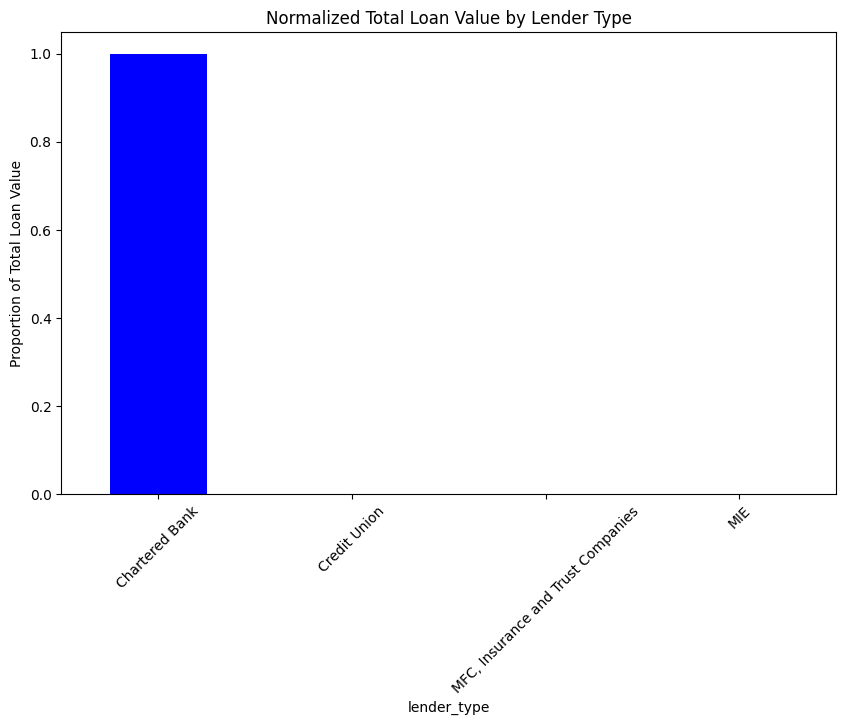

In [8]:
#-------------------Value Normalization--------------------

grouped_data = merged_data.groupby('lender_type')['total_loan_value_outstanding_($)'].sum()
grouped_data_normalized = grouped_data / grouped_data.sum()
print("Normalized Total Loan Value by Lender Type:")
print(grouped_data_normalized)
plt.figure(figsize=(10, 6))
grouped_data_normalized.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.title("Normalized Total Loan Value by Lender Type")
plt.ylabel("Proportion of Total Loan Value")
plt.xticks(rotation=45)
plt.show()

Chartered Banks dominate the residential mortgage market with a significantly higher total loan value compared to other lenders such as Credit Unions, MIEs, and MFCs. This dominance reflects their extensive market presence and influence in the industry, as seen in the stark disparity in loan proportions.

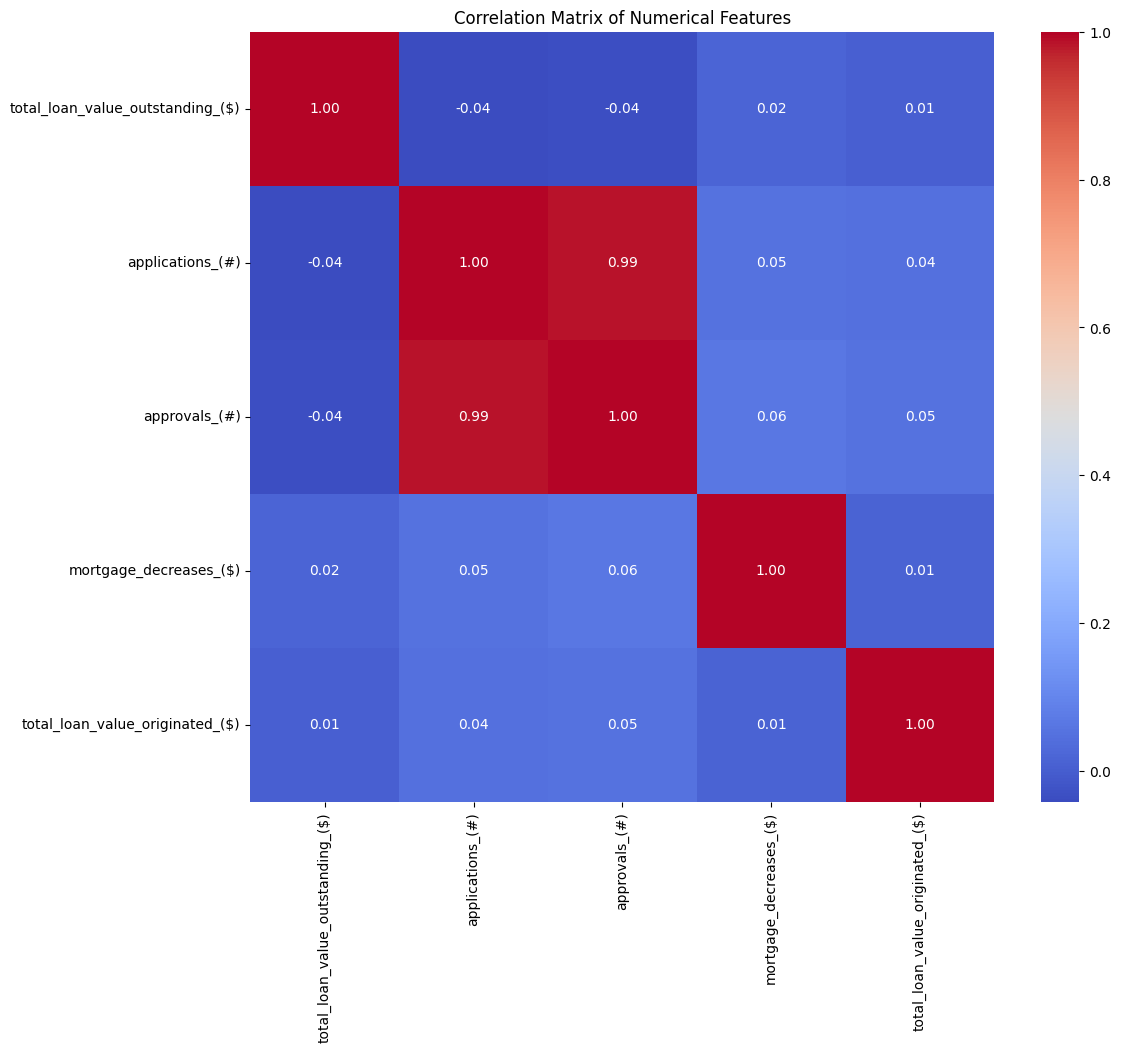

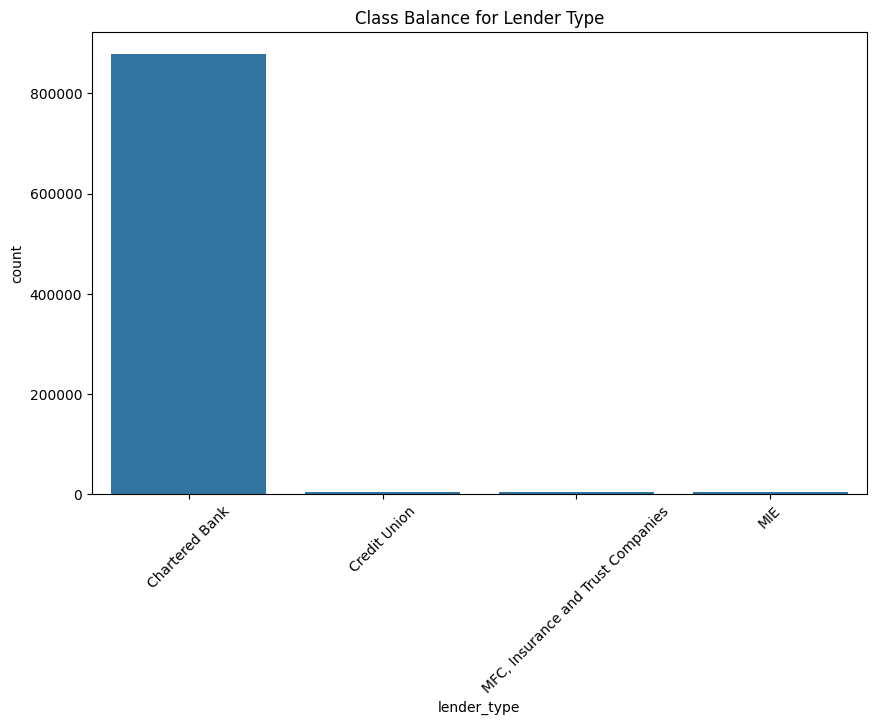

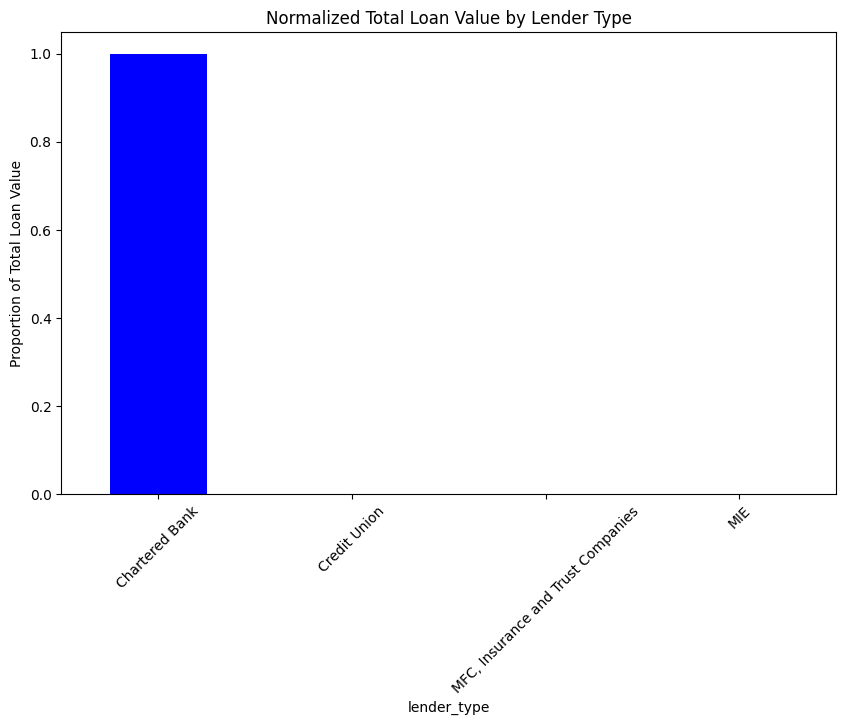

In [9]:
## ------------------------ Exploratory Data Analysis ------------------------

# Correlation matrix of numerical features
plt.figure(figsize=(12, 10))
numerical_columns = merged_data.select_dtypes(include=np.number)
sns.heatmap(numerical_columns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Class balance for lender type
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, x='lender_type', order=merged_data['lender_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Class Balance for Lender Type")
plt.show()

# Exploring normalized total loan value across all lenders
grouped_data = merged_data.groupby('lender_type')['total_loan_value_outstanding_($)'].sum()
grouped_data_normalized = grouped_data / grouped_data.sum()

plt.figure(figsize=(10, 6))
grouped_data_normalized.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.title("Normalized Total Loan Value by Lender Type")
plt.ylabel("Proportion of Total Loan Value")
plt.xticks(rotation=45)
plt.show()


Outliers in the dataset represent extreme values, such as unusually high mortgage decreases or loan values. These likely reflect real-world variability caused by economic fluctuations, specific lender practices, or unique events. Retaining these outliers ensures the analysis captures the full scope of the data, providing a more comprehensive understanding.

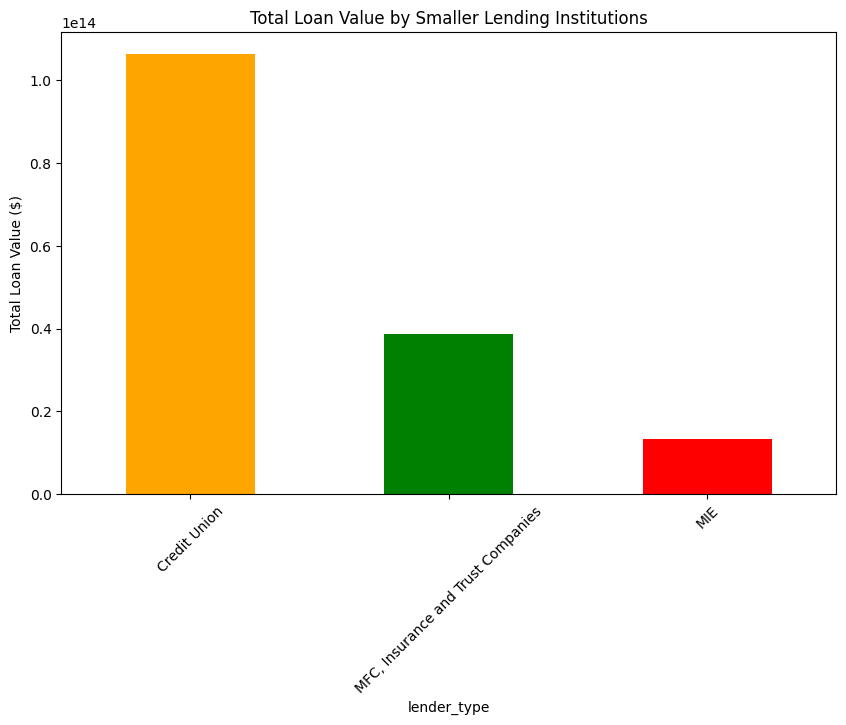

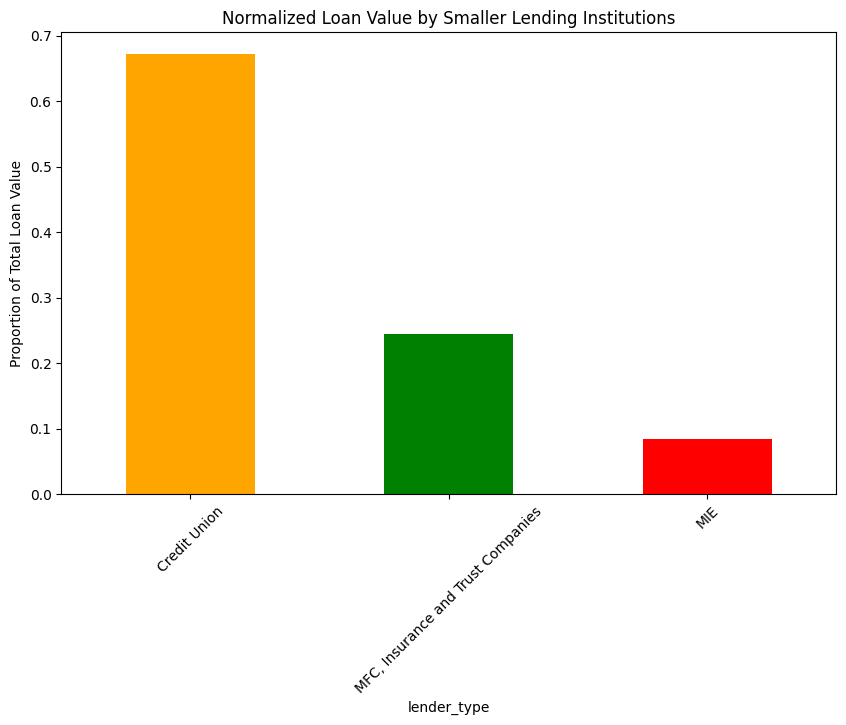

In [10]:
# ------------------------ Smaller Lending Institutions ------------------------

# Filtering data for smaller lending institutions (exclude Chartered Bank)
smaller_lenders = merged_data[merged_data['lender_type'] != 'Chartered Bank']

# Grouping by lender type and calculate total loan values for smaller lenders
grouped_smaller_lenders = smaller_lenders.groupby('lender_type')['total_loan_value_outstanding_($)'].sum()

# Total loan values for smaller lending institutions
plt.figure(figsize=(10, 6))
grouped_smaller_lenders.plot(kind='bar', color=['orange', 'green', 'red'])
plt.title("Total Loan Value by Smaller Lending Institutions")
plt.ylabel("Total Loan Value ($)")
plt.xticks(rotation=45)
plt.show()

# Normalizing total loan values for smaller lending institutions
grouped_smaller_lenders_normalized = grouped_smaller_lenders / grouped_smaller_lenders.sum()

plt.figure(figsize=(10, 6))
grouped_smaller_lenders_normalized.plot(kind='bar', color=['orange', 'green', 'red'])
plt.title("Normalized Loan Value by Smaller Lending Institutions")
plt.ylabel("Proportion of Total Loan Value")
plt.xticks(rotation=45)
plt.show()

The bar charts illustrate the distribution of total loan values among smaller lending institutions (excluding Chartered Banks). The Credit Union emerges as the leading contributor, holding approximately 60-70% of the total loan value among smaller institutions. MFC, Insurance and Trust Companies follow with a moderate share, while MIE contributes the least. This disparity underscores the dominant role of Credit Unions in the smaller lender segment, with the others playing more specialized or niche roles in the mortgage market.

In [11]:
# ------------------------ Data Preparation ------------------------

# Encoding categorical variables for use in the model
applications['lender_type_encoded'] = LabelEncoder().fit_transform(applications['lender_type'])
approvals['lender_type_encoded'] = LabelEncoder().fit_transform(approvals['lender_type'])
mortgage_decreases['lender_type_encoded'] = LabelEncoder().fit_transform(mortgage_decreases['lender_type'])

# Merging datasets to create a unified modeling dataset
model_data = pd.merge(applications, approvals, on=['reporting_date', 'lender_type'])
model_data = pd.merge(model_data, mortgage_decreases, on=['reporting_date', 'lender_type'], how='inner')

In [12]:
# ------------------------ Feature Engineering ------------------------

# Feature engineering
model_data['approval_rate'] = model_data['approvals_(#)'] / model_data['applications_(#)']
model_data['decrease_percentage'] = (
    model_data['mortgage_decreases_($)'] / model_data['applications_(#)']
).fillna(0)

# Features and target variable for modeling
X = model_data[['applications_(#)', 'lender_type_encoded', 'approval_rate', 'decrease_percentage']]
y = model_data['approvals_(#)']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data prepared for modeling. Training and testing datasets created.")

Data prepared for modeling. Training and testing datasets created.


Machine learning will be used to predict the number of loan approvals by identifying patterns and relationships within the data that are not easily captured through traditional analysis. Models such as Random Forest, Gradient Boosting, and Linear Regression will be applied to evaluate their effectiveness in making accurate predictions and understanding the key factors influencing approvals. These models are chosen for their ability to handle complex datasets and provide reliable insights.

<ipython-input-13-adfd0db7eae5>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_df, x="Model", y="RMSE", palette="viridis")


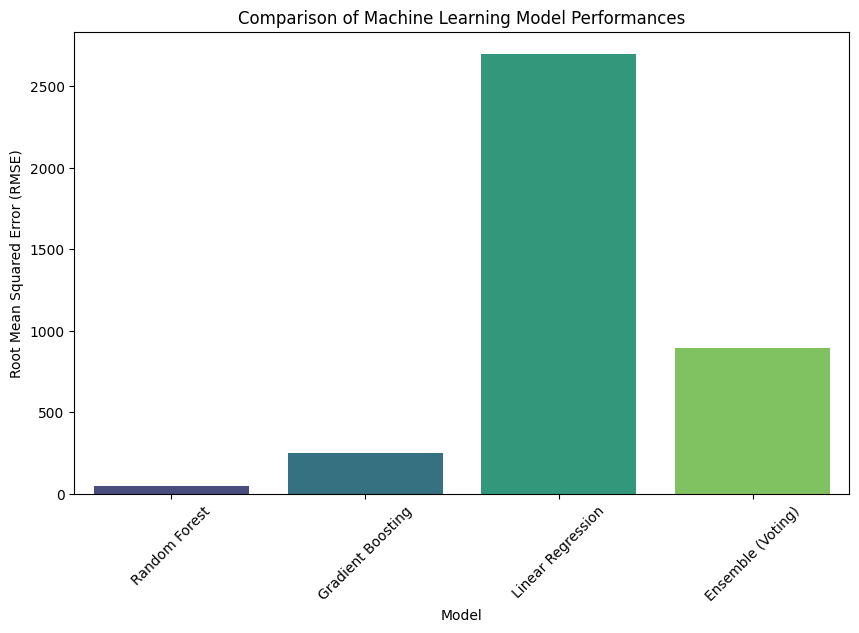

Best Model: Random Forest with RMSE: 49.23


In [13]:

# ------------------------ Machine Learning Models and Comparisons ------------------------

# Model 1: Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_model.predict(X_test)))

# Model 2: Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_model.predict(X_test)))

# Model 3: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_model.predict(X_test)))

# Ensemble: Voting Regressor
ensemble_model = VotingRegressor(estimators=[('rf', rf_model), ('gb', gb_model), ('lr', lr_model)])
ensemble_model.fit(X_train, y_train)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_model.predict(X_test)))

model_rmse = {
    "Random Forest": rf_rmse,
    "Gradient Boosting": gb_rmse,
    "Linear Regression": lr_rmse,
    "Ensemble (Voting)": ensemble_rmse
}

rmse_df = pd.DataFrame(list(model_rmse.items()), columns=["Model", "RMSE"])

plt.figure(figsize=(10, 6))
sns.barplot(data=rmse_df, x="Model", y="RMSE", palette="viridis")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Comparison of Machine Learning Model Performances")
plt.xticks(rotation=45)
plt.show()

best_model = rmse_df.loc[rmse_df['RMSE'].idxmin()]
print(f"Best Model: {best_model['Model']} with RMSE: {best_model['RMSE']:.2f}")

In [15]:
from sklearn.metrics import mean_absolute_error

# ------------------------ Model Performance Metrics ------------------------


# Define a function to calculate all metrics for a given model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100  # MAPE as a percentage
    r2 = r2_score(y_test, predictions)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R²": r2}

# Evaluate Random Forest
rf_metrics = evaluate_model(rf_model, X_test, y_test)

# Evaluate Gradient Boosting
gb_metrics = evaluate_model(gb_model, X_test, y_test)

# Evaluate Linear Regression
lr_metrics = evaluate_model(lr_model, X_test, y_test)

# Display results
print("Random Forest Metrics:", rf_metrics)
print("Gradient Boosting Metrics:", gb_metrics)
print("Linear Regression Metrics:", lr_metrics)

# Optional: Tabular display for comparison
import pandas as pd
metrics_df = pd.DataFrame([rf_metrics, gb_metrics, lr_metrics],
                          index=["Random Forest", "Gradient Boosting", "Linear Regression"])
print(metrics_df)

Random Forest Metrics: {'RMSE': 49.231320547246845, 'MAE': 22.405326086979702, 'MAPE': 0.0096437157865274, 'R²': 0.9999994481170771}
Gradient Boosting Metrics: {'RMSE': 253.30646733412053, 'MAE': 177.34859807813146, 'MAPE': 0.05737488474615459, 'R²': 0.99998538978719}
Linear Regression Metrics: {'RMSE': 2697.0722085376374, 'MAE': 1884.16562572102, 'MAPE': 0.766954493851314, 'R²': 0.9983436613603388}
                          RMSE          MAE      MAPE        R²
Random Forest        49.231321    22.405326  0.009644  0.999999
Gradient Boosting   253.306467   177.348598  0.057375  0.999985
Linear Regression  2697.072209  1884.165626  0.766954  0.998344


The machine learning models developed in this project demonstrated varying levels of performance in predicting loan approvals. The Random Forest model emerged as the best-performing model, achieving an RMSE of 49.23, MAE of 22.41, MAPE of 0.0096%, and an R² of 0.999999, indicating exceptional predictive accuracy. However, the near-perfect R² score suggests potential overfitting, warranting further validation with unseen data.

The Gradient Boosting model also performed well, with an RMSE of 253.31 and a slightly lower R² of 0.999985, but it was less precise than Random Forest. In contrast, Linear Regression struggled to capture the complexity of the data, resulting in a high RMSE of 2697.07 and a MAPE of 0.767%, making it unsuitable for this task.

These metrics validate the Random Forest model as the most reliable for this dataset, while highlighting the importance of careful evaluation and potential adjustments to ensure robustness for real-world applications. Future work should focus on validating the model further and addressing overfitting concerns.